Goal: get a class of regression function

# step 1 define the learning model

In [1]:
from mlkl_util import *
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
kernel_gamma = 1.0 # kernel parameter

In [3]:
this_kernel = rbf_kernel

In [4]:
n_x = 10 # num samples
n_dim = 2 # dim of each point
a = np.ones(n_x)/n_x # uniform weightsa
data = np.random.uniform(-1, 1, size=[n_x, n_dim])

In [5]:
f0 = rkhsFun(this_kernel, kernel_gamma, n_x = n_x)  # create the RKHS function

## mini unit test, plot an RKHS function

In [6]:
n_x = 10 # num samples
n_dim = 2 # dim of each point
# a = np.ones(n_x)/n_x # uniform weights

In [7]:

data = np.random.uniform(-1, 1, size=[n_x, n_dim])

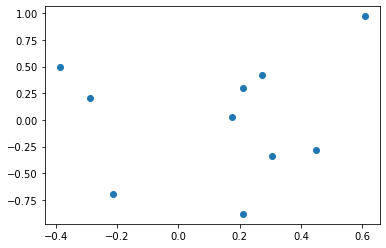

In [8]:
# data to approximate
plt.scatter(x=data[:,0], y=data[:,1])

In [9]:
x_grid = np.linspace(-1, 1, 100)

In [10]:
x_grid = x_grid.reshape(-1,1)

In [11]:
x_grid.shape

(100, 1)

In [12]:
data[:,0].shape

(10,)

In [13]:
# evaluate the RKHS function on grid points to produce a continuous function
f_vals = f0(x_grid, data[:,0].reshape(-1,1)) 

In [14]:
f_vals

tensor([[2.1536, 2.2302, 2.3080, 2.3868, 2.4666, 2.5474, 2.6291, 2.7115, 2.7947,
         2.8785, 2.9628, 3.0475, 3.1326, 3.2178, 3.3033, 3.3887, 3.4740, 3.5591,
         3.6439, 3.7283, 3.8121, 3.8952, 3.9775, 4.0589, 4.1392, 4.2184, 4.2963,
         4.3727, 4.4476, 4.5209, 4.5923, 4.6619, 4.7294, 4.7948, 4.8579, 4.9187,
         4.9770, 5.0327, 5.0858, 5.1360, 5.1835, 5.2280, 5.2694, 5.3077, 5.3429,
         5.3748, 5.4034, 5.4287, 5.4505, 5.4689, 5.4838, 5.4952, 5.5030, 5.5073,
         5.5080, 5.5051, 5.4986, 5.4886, 5.4750, 5.4579, 5.4373, 5.4133, 5.3858,
         5.3550, 5.3209, 5.2835, 5.2429, 5.1993, 5.1526, 5.1030, 5.0505, 4.9952,
         4.9373, 4.8768, 4.8139, 4.7486, 4.6811, 4.6115, 4.5399, 4.4664, 4.3912,
         4.3143, 4.2359, 4.1562, 4.0752, 3.9930, 3.9099, 3.8259, 3.7412, 3.6559,
         3.5701, 3.4839, 3.3975, 3.3110, 3.2244, 3.1379, 3.0517, 2.9658, 2.8803,
         2.7954]], grad_fn=<MmBackward0>)

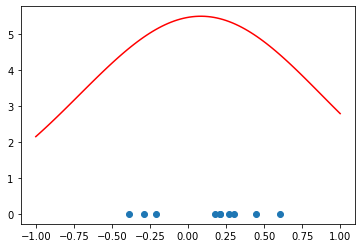

In [15]:
plt.plot(x_grid, f_vals.squeeze().detach().numpy(), c='r') # plot the uniform weights interpolant
plt.scatter(x=data[:,0], y=np.zeros_like(data[:,0]))

# Try a different coefficent set than the uniform
a_prime = np.random.rand(n_x) # uniform weights
a_prime = a_prime / np.sum(a_prime)

f_vals_prime = f0(x_grid, a_prime.T, data[:,0].reshape(-1,1)) 
plt.plot(x_grid, f_vals_prime, c='r') # plot the uniform weights interpolant
plt.scatter(x=data[:,0], y=np.zeros_like(data[:,0]))

This of course is not the funciton we wanted. Now let's perform regression.

# Ridge Regression

i.e., solve for the coefficient function a

instead of matrix inversion, we use iterative schemes

we use auto diff in pytorch to get gradient of the objective w.r.t. coefficient a

In [16]:
f_th = rkhsFun(this_kernel, kernel_gamma, is_torch=True, n_x = n_x)  # create the RKHS function

In [17]:
# create data used for training
# a = torch.rand(n_x, requires_grad=True) # uniform weightsa
data_th = 2*np.pi *torch.from_numpy(data[:,0])

## generate the target data

In [18]:
target_th = torch.sin(data_th) + 0.2 * torch.rand_like(data_th)

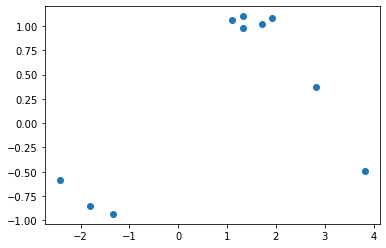

In [19]:
plt.scatter(x=data_th, y=target_th)

In [20]:
f_val = f_th(data_th.reshape(-1,1), data_th.reshape(-1,1)) 

## mini test, make sure getting the same thing form Torch and numpy

In [21]:
f_val_np = f0(data_th.numpy().reshape(-1,1), data_th.numpy().reshape(-1,1)) 

In [22]:
# they should be the same
f_val

tensor([[1.8422, 1.5293, 1.5918, 1.5906, 0.9055, 0.8155, 1.6188, 1.8272, 1.6150,
         1.3962]], grad_fn=<MmBackward0>)

In [23]:
f_val_np

tensor([[2.5191, 1.3698, 1.6930, 2.0090, 1.6645, 0.7430, 2.3161, 2.5872, 2.3103,
         1.9727]], grad_fn=<MmBackward0>)

## construct objective

In [24]:
def plot_sol_rkhs(a, data_th):
    x_grid = torch.linspace(torch.min(data_th), torch.max(data_th), 100).reshape(-1, 1)
    f_val_plot = f_th(x_grid, data_th.reshape(-1, 1))
    plt.plot(x_grid.detach().numpy(),
             f_val_plot.detach().numpy().reshape(-1,1),
             c='r')  # plot the uniform weights interpolant


In [25]:
# moved to util.py
# def gd_step(data_th=None, step_size=0.001):
#     # f_th: parameterized rkhs function
#     # data_th: data in torch array
    
#     # construct the graph (again?)
#     f_val = f_th(data_th.reshape(-1,1), a.T, data_th.reshape(-1,1)) 
#     f_minus_y_sqr = torch.norm(f_val - target_th)**2 # frobenius/2-norm sqr

#     K =  this_kernel(data_th.reshape(-1,1), data_th.reshape(-1,1), gamma=kernel_gamma)
#     aKa = torch.mm(torch.mm(a.reshape(1,-1), torch.from_numpy(K).float()), a.reshape(-1,1))

#     reg_coeff = 0.1
#     reg_term = reg_coeff * aKa

#     obj_krr = f_minus_y_sqr + reg_term

#     # back prop
#     obj_krr.backward() # compute grad

#     # gradient step
#     a.data = a - step_size * a.grad.detach() # gradient step

#     a.grad.zero_() # zero gradient

In [26]:
# raise NotImplemented

## before optimization plot

In [35]:
# initialize
f_th.__init__(this_kernel, kernel_gamma, is_torch=True, n_x = n_x)  # create the RKHS function

In [36]:
f_th.a.detach().numpy()

array([0.28013396, 0.6068603 , 0.31946772, 0.40140265, 0.95106775,
       0.77903074, 0.22091252, 0.3655119 , 0.8714077 , 0.53567874],
      dtype=float32)

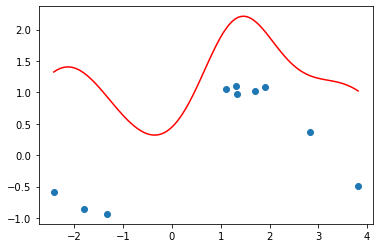

In [37]:
plot_sol_rkhs(f_th.a, data_th)
plt.scatter(x=data_th, y=target_th)

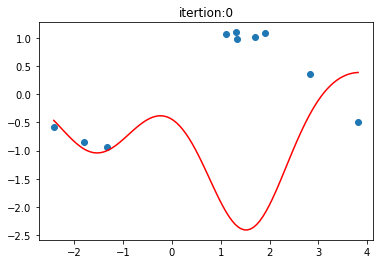

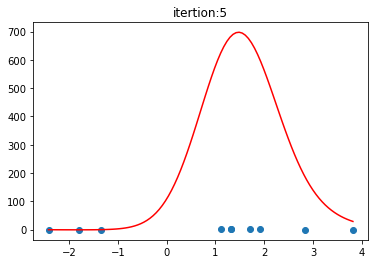

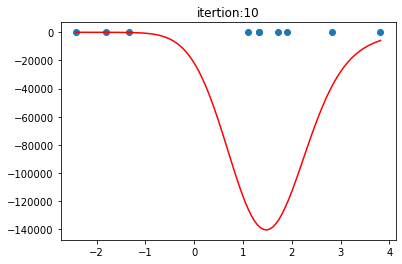

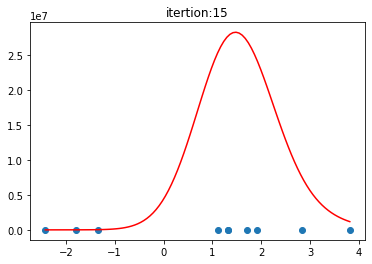

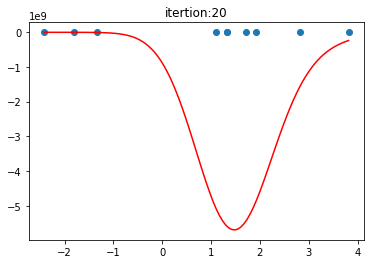

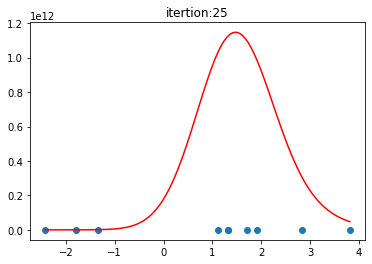

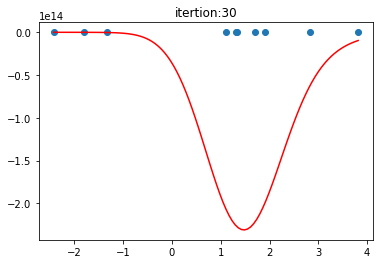

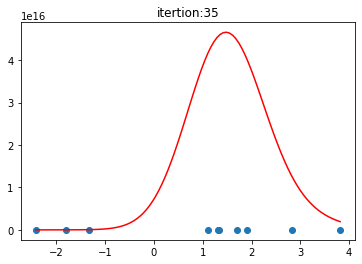

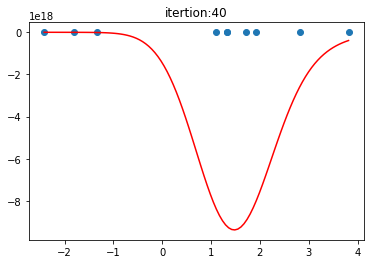

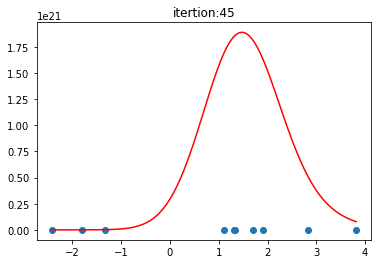

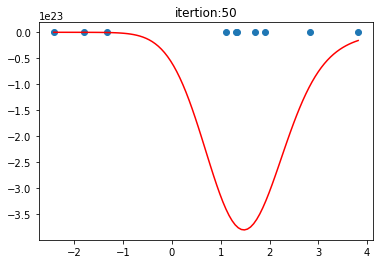

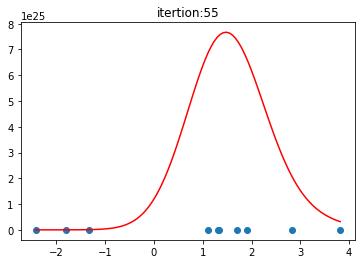

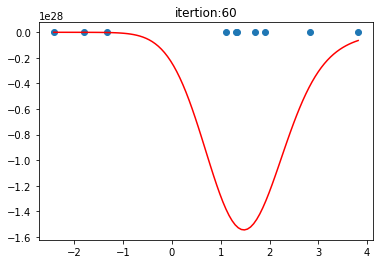

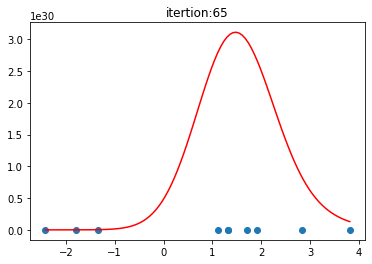

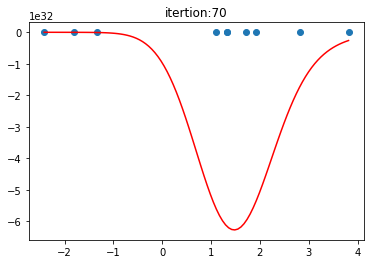

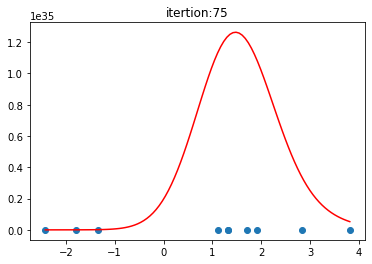

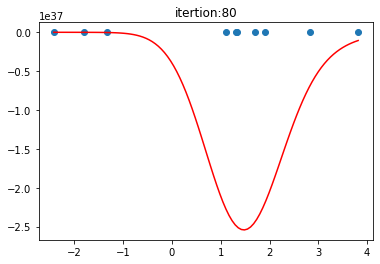

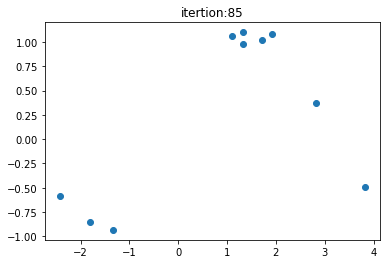

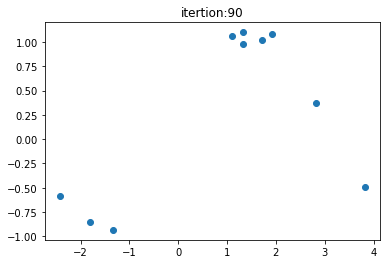

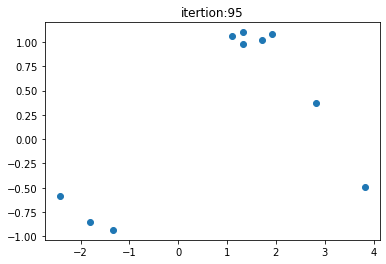

In [38]:
for iter_gd in range(100):
    f_th.gd_step(x_th =data_th, y_th = target_th, step_size=0.1, reg_coeff = 0.1)
    if iter_gd %5 ==0:
        plt.figure()
        plot_sol_rkhs(f_th.a, data_th)
        plt.scatter(x=data_th, y=target_th)
        plt.title("itertion:"+str(iter_gd))

## after optimization plot

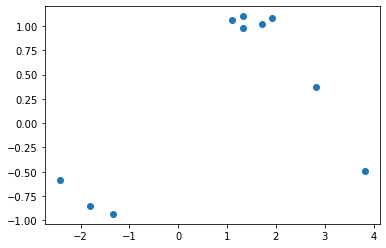

In [30]:
plot_sol_rkhs(f_th.a, data_th)
plt.scatter(x=data_th, y=target_th)

# SGD, load data
instead of the whole data batch, we only load the small data batch

In [32]:
import random

In [33]:
g_th = rkhsFun(this_kernel, kernel_gamma, is_torch=True)  # create the RKHS function

In [34]:
# build a randomized data loader



# todo later, we will use mini-batches

In [35]:
# sgd iter's

for iter_gd in range(100):
    # we generate a random index
    id_rnd = random.randint(0, n_x)
    
    # gradient step
    gd_step(g_th, data_th =data_th[id_rnd], step_size=0.1)
    if iter_gd %20 ==0:
        plt.figure()
        plot_sol_rkhs(a, data_th)
        plt.scatter(x=data_th, y=target_th)
        plt.title("itertion:"+str(iter_gd))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 1x1)